### Init

In [7]:
from dotenv import load_dotenv
import sys, os 
from lib.seed import seed_prefix 
load_dotenv()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
seed_prefix(seed = 42)

Seed Fix: 42


### [1]-[2]

In [8]:
from lib.dataset import data_split
import pandas as pd 
data_df = pd.read_csv(os.getenv('DATASHEET_PATH'))
data_dir = os.getenv('DATA_DIR')
train_df, test_df = data_split(data_df, split_num = 5)

In [11]:
from lib.dataset import PCOS_Dataset
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader

binary_use = False
test_dataset = PCOS_Dataset(
    data_filenames = test_df['filename'],
    data_dir_path  = data_dir,
    labels         = test_df['label|0:양성, 1:중간형, 2:악성'],
    binary_use = binary_use,
    need_paths = True,
    transform = v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop((224, 224)),
        v2.Grayscale(num_output_channels=3),
        v2.ToTensor(),
    ])
)

test_bs = 24
test_loader = DataLoader(test_dataset, batch_size = test_bs, shuffle = False, pin_memory=True, pin_memory_device= "cuda:0", persistent_workers=True, prefetch_factor = 4, num_workers= 8, )


[Alert] Sample Dataset Use : False


/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


592


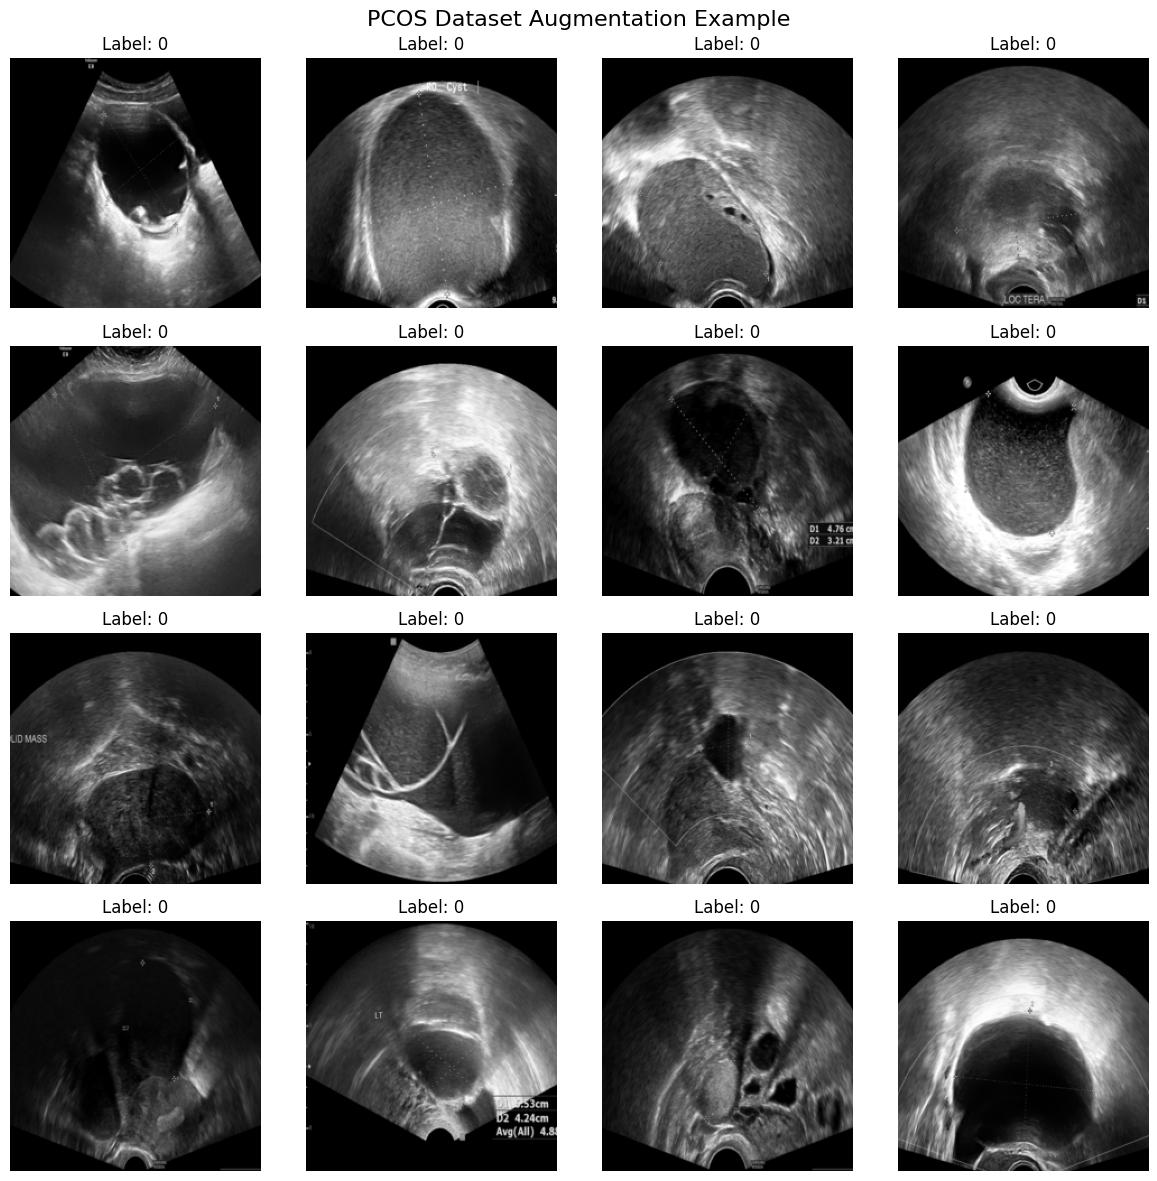

In [12]:
print(len(test_dataset))
# %% Test Augmentation 
X, y, paths = next(iter(test_loader))
import matplotlib.pyplot as plt
try: 
    fig, axes = plt.subplots(4, 4, figsize = (12, 12))
    fig.suptitle('PCOS Dataset Augmentation Example', fontsize = 16)
    for i in range(16):
        axes[i//4, i%4].imshow(X[i].cpu().permute(1, 2, 0).numpy())
        axes[i//4, i%4].set_title(f'Label: {y[i].item():.0f}')
        axes[i//4, i%4].axis('off')

    plt.tight_layout()
    plt.show()
    pass
except:
    pass

# Model Load

In [5]:
import torch 
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### [Settings] Train - Hyper Parmas 정의

In [6]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import datetime
from sklearn.metrics import roc_auc_score
import json
from loss import Poly1FocalLoss, Poly1CrossEntropyLoss
import datetime

### [Settings] Testing 모델 정의

In [8]:
import json 
import glob 
import os
from tqdm import tqdm
from models import Model_Loader
from visualize import plot_roc_curve, visualize_confidence_scores
from metric import calculate_metrics, plot_confusion_matrix_from_preds
import gc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

num_classes = 1 if binary_use else 3

exp_model_paths = glob.glob(pathname = '/home/eiden/eiden/PCOS-roi-classification/v2/log/2504232359/*.json')
metric_dict = dict()

# ROC 곡선 비교를 위한 데이터 저장
all_models_roc_data = []

for exp_model_path in exp_model_paths:
    # 모델 설정
    model_dict = json.load(open(exp_model_path))
    model_weight = model_dict['model_path']
    model_name = model_dict['model_path'].split('/')[-1].split('.')[0]
    print(f"[Info] 모델 로딩: {model_name}")
    
    # 모델 로드
    weight = torch.load(model_weight)
    model = Model_Loader(model_name=model_name, num_classes=num_classes).to(device)
    model.load_state_dict(weight)
    model.eval()
    
    # 저장 디렉토리 설정
    save_dir = model_weight.replace('.pth', '')
    os.makedirs(save_dir, exist_ok=True)
    
    # TP/FP/TN/FN 하위 폴더 생성
    for subf in ['TP', 'TN', 'FP', 'FN']:
        os.makedirs(os.path.join(save_dir, subf), exist_ok=True)

    all_preds = []
    all_labels = []
    
    # 테스트 데이터 추론
    for X, label, filepaths in tqdm(test_loader, total=len(test_loader)):
        with torch.no_grad():
            X, label = X.to(device), label.to(device)
            if len(X.shape) == 3:  # (C, H, W) -> (B, C, H, W)
                X = X.unsqueeze(0)
            
            y_res = model(X)
            
            if binary_use:
                y_prob = torch.sigmoid(y_res).detach().cpu()
            else:
                y_prob = F.softmax(y_res, dim=1).detach().cpu()
            
            all_preds.append(y_prob)
            all_labels.append(label.detach().cpu())
            gc.collect()
    
    # 테스트 메트릭 계산
    test_preds = torch.cat(all_preds, dim=0)
    test_labels = torch.cat(all_labels, dim=0)
    
    # 클래스 이름 설정
    if binary_use:
        class_names = ['양성', '악성']
    else: 
        class_names = ['양성', '중간형', '악성']
    
    # ROC 곡선 그리기 및 최적 임계값 찾기
    if binary_use:
        # 개별 모델 ROC 곡선 그리기
        plot_roc_curve(
            true_labels=test_labels,
            pred_probs=test_preds,
            binary_use=binary_use,
            save_path=model_weight.replace('.pth', '_ROC.png'),
            class_names=class_names
        )
        
        # 전체 비교를 위한 ROC 데이터 계산
        fpr, tpr, thresholds = roc_curve(test_labels.numpy(), test_preds.numpy())
        auc_score = auc(fpr, tpr)
        
        all_models_roc_data.append({
            'model_name': model_name,
            'fpr': fpr,
            'tpr': tpr,
            'auc': auc_score
        })
        
        optimal_threshold = thresholds[np.argmax(tpr - fpr)]
        optimal_threshold = float(optimal_threshold)
        
        # 혼동 행렬 그리기
        plot_confusion_matrix_from_preds(
            test_labels, 
            test_preds, 
            binary_use=binary_use, 
            class_names=class_names, 
            save_path=model_weight.replace('.pth', '_CM.png'), 
            normalize=True, 
            threshold=optimal_threshold
        )
        
        # 메트릭 계산
        metric_dict[model_name] = calculate_metrics(
            labels=test_labels, 
            preds=test_preds, 
            binary_use=binary_use, 
            threshold=optimal_threshold
        )
    else:
        # 다중 클래스 처리
        optimal_thresholds = []
        class_roc_data = []
        
        for class_idx in range(test_preds.shape[1]):
            # 개별 모델 ROC 곡선 그리기
            plot_roc_curve(
                true_labels=(test_labels == class_idx).float(),
                pred_probs=test_preds[:, class_idx],
                binary_use=True,
                save_path=model_weight.replace('.pth', f'_ROC_Class{class_idx}.png'),
                class_names=[f'Class {class_idx}', f'Not Class {class_idx}']
            )
            
            # 전체 비교를 위한 ROC 데이터 계산
            class_probs = test_preds[:, class_idx].numpy()
            class_labels = (test_labels == class_idx).float().numpy()
            fpr, tpr, thresholds = roc_curve(class_labels, class_probs)
            auc_score = auc(fpr, tpr)
            
            class_roc_data.append({
                'class_idx': class_idx,
                'fpr': fpr,
                'tpr': tpr,
                'auc': auc_score
            })
            
            optimal_threshold = thresholds[np.argmax(tpr - fpr)]
            optimal_thresholds.append(float(optimal_threshold))
        
        all_models_roc_data.append({
            'model_name': model_name,
            'class_data': class_roc_data
        })
        
        # 다중 클래스 혼동 행렬
        plot_confusion_matrix_from_preds(
            test_labels, 
            test_preds, 
            binary_use=binary_use, 
            class_names=class_names, 
            save_path=model_weight.replace('.pth', '_CM.png'), 
            normalize=True, 
            threshold=optimal_thresholds
        )
        
        # 다중 클래스 메트릭 계산
        metric_dict[model_name] = calculate_metrics(
            labels=test_labels, 
            preds=test_preds, 
            binary_use=binary_use, 
            threshold=optimal_thresholds
        )
        metric_dict[model_name]['Best Thresholds'] = optimal_thresholds

    # 신뢰도 시각화
    visualize_confidence_scores(
        test_preds,
        test_labels,
        class_names=class_names,
        save_path=model_weight.replace('.pth', '_Confidence.png')
    )
    
    # 메모리 정리
    torch.cuda.empty_cache()
    gc.collect()

# 모든 모델의 ROC 곡선을 하나의 그래프로 통합
plt.figure(figsize=(10, 8))

if binary_use:
    for model_data in all_models_roc_data:
        plt.plot(
            model_data['fpr'], 
            model_data['tpr'], 
            label=f"{model_data['model_name']} (AUC = {model_data['auc']:.3f})"
        )
else:
    # 각 클래스별로 별도의 서브플롯 생성
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
    
    for class_idx in range(num_classes):
        for model_data in all_models_roc_data:
            class_data = model_data['class_data'][class_idx]
            axes[class_idx].plot(
                class_data['fpr'], 
                class_data['tpr'], 
                label=f"{model_data['model_name']} (AUC = {class_data['auc']:.3f})"
            )
        
        axes[class_idx].plot([0, 1], [0, 1], 'k--')
        axes[class_idx].set_xlabel('False Positive Rate')
        axes[class_idx].set_ylabel('True Positive Rate')
        axes[class_idx].set_title(f'ROC Curve - {class_names[class_idx]}')
        axes[class_idx].legend(loc='lower right')
        axes[class_idx].grid(True)

if binary_use:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('모든 모델의 ROC 곡선 비교')
    plt.legend(loc='lower right')
    plt.grid(True)

# 저장 경로 설정 (첫 번째 모델의 경로를 기준으로)
base_save_dir = os.path.dirname(exp_model_paths[0])
plt.tight_layout()
plt.savefig(os.path.join(base_save_dir, 'total_ROC.png'), dpi=300)
plt.close()

# 결과 데이터프레임 생성
metric_df = pd.DataFrame(metric_dict).T
metric_df.to_csv(os.path.join(base_save_dir, 'metric_results.csv'), index=True)

[Info] 모델 로딩: vit_l_16


100%|██████████| 25/25 [00:04<00:00,  5.28it/s]


[Info] 모델 로딩: dinov2_vits14_lc


Using cache found in /home/eiden/.cache/torch/hub/facebookresearch_dinov2_main
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


[Info] 모델 로딩: convnext_s


/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


[Info] 모델 로딩: resnet_18


100%|██████████| 25/25 [00:03<00:00,  7.88it/s]


[Info] 모델 로딩: maxvit_t


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


[Info] 모델 로딩: mobilenet_l


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


<Figure size 1000x800 with 0 Axes>

In [9]:
metric_df

,auc,f1,accuracy,recall,auc_per_class,f1_per_class,recall_per_class,accuracy_per_class,Best Thresholds
vit_l_16,0.796909,0.565991,0.755068,0.547546,"[0.8398736685974402, 0.8757581561642087, 0.675...","[0.8507109004739336, 0.636734693877551, 0.2105...","[0.9134860050890585, 0.5652173913043478, 0.163...","[0.9134860050890585, 0.5652173913043478, 0.163...","[0.5748025178909302, 0.3509710431098938, 0.097..."
dinov2_vits14_lc,0.812599,0.588166,0.758446,0.562663,"[0.855767386551076, 0.8629094043286727, 0.7191...","[0.8598130841121495, 0.5943396226415094, 0.310...","[0.9363867684478372, 0.45652173913043476, 0.29...","[0.9363867684478372, 0.45652173913043476, 0.29...","[0.8314260244369507, 0.05645851418375969, 0.04..."
convnext_s,0.78503,0.534958,0.739865,0.508652,"[0.812446456199573, 0.8697727127625614, 0.6728...","[0.8411428571428572, 0.583732057416268, 0.18]","[0.9363867684478372, 0.4420289855072464, 0.147...","[0.9363867684478372, 0.4420289855072464, 0.147...","[0.6496832966804504, 0.1529524028301239, 0.114..."
resnet_18,0.73424,0.504245,0.728041,0.488952,"[0.7567097574385925, 0.8124401455659835, 0.633...","[0.8283752860411899, 0.5638766519823789, 0.120...","[0.9211195928753181, 0.463768115942029, 0.0819...","[0.9211195928753181, 0.463768115942029, 0.0819...","[0.5509137511253357, 0.2770668566226959, 0.156..."
maxvit_t,0.725413,0.488879,0.721284,0.469715,"[0.7599191888194152, 0.8403881759560747, 0.575...","[0.8359550561797753, 0.48484848484848486, 0.14...","[0.9465648854961832, 0.34782608695652173, 0.11...","[0.9465648854961832, 0.34782608695652173, 0.11...","[0.5925498008728027, 0.2022196352481842, 0.239..."
mobilenet_l,0.717835,0.419094,0.714527,0.426172,"[0.7426061605738618, 0.7858807380450745, 0.625...","[0.8207343412526998, 0.4365482233502538, 0.0]","[0.9669211195928753, 0.3115942028985507, 0.0]","[0.9669211195928753, 0.3115942028985507, 0.0]","[0.5173649191856384, 0.2584759593009949, 0.174..."
